In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE  
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data/categorized_specializations.csv')

In [3]:
# Handle skew by removing low-count university names
min_samples_per_class = 50
valid_classes = df['univName'].value_counts()
valid_classes = valid_classes[valid_classes >= min_samples_per_class].index
df = df[df['univName'].isin(valid_classes)]

In [4]:
# One-hot encoding univ_state 
df = pd.get_dummies(df, columns=['univ_state'], drop_first=True)

# Label encoding categorical columns
def encode_categorical_columns(df, categorical_columns):
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

# Scaling continuous columns
def scale_numerical_columns(df, numerical_columns):
    scaler = StandardScaler()
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan)
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler

In [5]:
# Train ML models 
def train_models(X_train, X_test, y_train, y_test, model_name_prefix):
    models = {
        'Random Forest': (RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1), {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True],
            'max_samples': [None, 0.8, 0.9] 
        })
    }

    trained_models = {}
    le_y = LabelEncoder()
    y_train_encoded = le_y.fit_transform(y_train)
    y_test_encoded = le_y.transform(y_test)

    for name, (model, param_grid) in models.items():
        print(f"\nTraining {name} for {model_name_prefix} Prediction with Hyperparameter Tuning and Regularization")
        
        search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=42)
        search.fit(X_train, y_train_encoded)
        
        best_model = search.best_estimator_
        best_params = search.best_params_
        
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test_encoded, y_pred)
        
        print(f"{name} Best Parameters: {best_params}")
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_test_encoded, y_pred))

        # Plot feature importance
        if hasattr(best_model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': best_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
            print("Feature Importances:")
            print(importance_df.to_string(index=False))
            ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
            plt.title(f"{name} Feature Importance for {model_name_prefix}")
            for i, v in enumerate(importance_df['Importance']):
                ax.text(v, i, f"{v:.4f}", color='black', va='center')
            plt.show()
        
        trained_models[name] = (best_model, le_y)
    return trained_models, le_y



Training Random Forest for University Prediction with Hyperparameter Tuning and Regularization
Random Forest Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Random Forest Accuracy: 0.6577
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       767
           1       0.15      0.20      0.17        10
           2       0.68      0.67      0.67       365
           3       1.00      1.00      1.00       179
           4       0.16      0.22      0.18        97
           5       0.26      0.28      0.27       151
           6       0.63      0.80      0.71        82
           7       1.00      1.00      1.00       484
           8       0.41      0.28      0.33        40
           9       0.25      0.24      0.24        21
          10       0.75      0.82      0.78       107
          11       0.15      0.13      0.1

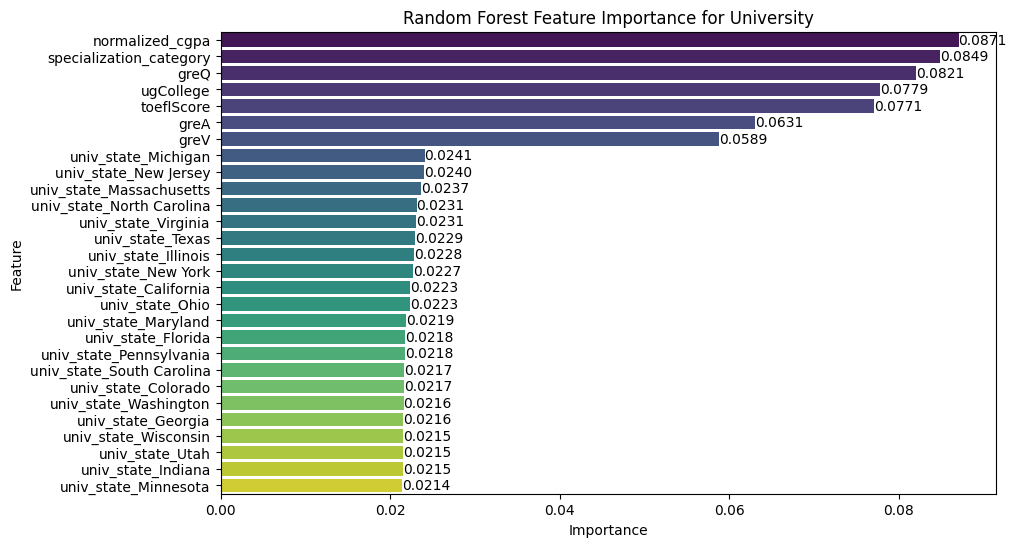

TruncatedSVD Explained Variance Ratio: 0.4904


In [7]:
univ_categorical = ['ugCollege', 'specialization_category']
univ_numerical = ['toeflScore', 'greV', 'greQ', 'greA', 'normalized_cgpa']

df, label_encoders_univ = encode_categorical_columns(df, univ_categorical)
df, scaler_univ = scale_numerical_columns(df, univ_numerical)

X_univ = df[univ_categorical + univ_numerical + [col for col in df.columns if 'univ_state_' in col]]
y_univ = df['univName']

X_univ_train, X_univ_test, y_univ_train, y_univ_test = train_test_split(X_univ, y_univ, test_size=0.2, random_state=42)

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_univ_train_resampled, y_univ_train_resampled = smote.fit_resample(X_univ_train, y_univ_train)

# Train models
models_univ, le_y_univ = train_models(X_univ_train_resampled, X_univ_test, y_univ_train_resampled, y_univ_test, 'University')

In [12]:
import os

# Define directory to save models
save_dir = "models/university_models"

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save models and preprocessing objects
joblib.dump(models_univ, os.path.join(save_dir, 'rf_university.pkl'))
joblib.dump(scaler_univ, os.path.join(save_dir, 'scaler_university.pkl'))
joblib.dump(label_encoders_univ, os.path.join(save_dir, 'label_encoders_university.pkl'))
joblib.dump(le_y_univ, os.path.join(save_dir, 'le_y_univ.pkl'))


['models/university_models\\knn_univ.pkl']